In [1]:
from cmath import sqrt
from turtle import color
from matplotlib import projections
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scipy.constants as spc
from matplotlib import cm
from scipy.optimize import curve_fit

In [2]:
# Funzione usata per controllare che si è al bordo della scatola
def IsOverBoundary(i, j, N, boundary):
    return i == 0 or j == 0 or i == N-1 or j == N-1

In [3]:
# Funzione con le condizioni al contorno e algoritmo SOR per il calcolo del potenziale
def SORAlg(f, rho, h, w, i, j, N, boundary, pos1, pos2):
    # La lunghezza della piastra è data dalla differenza tra fine e inizio
    inizio = int((1/5) * N)
    fine = int((4/5) * N)
    if(IsOverBoundary(i, j, N, boundary)):
        return 0
    
    # Identifica la posizione lungo le x della prima piastra e
    # pone a 1 il potenziale nei punti che vanno da inizio a fine
    if(j == pos1 and i <= fine and i >= inizio):
        return 1
    
    # Identifica la posizione della seconda piastra e
    # pone a -1 il potenziale nei punti che vanno da inizio a fine
    if(j == pos2 and i <= fine and i >= inizio):
        return -1
    
    # Calcola il nuovo pontenziale nel punto conoscendo il vecchio potenziale nei punti attorno
    newf = 0.25 * w * (f[i+1, j] + f[i-1, j] +\
                        f[i, j+1] + f[i, j-1] +\
                         rho[i, j] * h**2) + (1 - w) * f[i, j]
    return newf
        

In [4]:
# Funzione che calcola il potenziale in tutti i punti della griglia
def Step(f, rho, h, w, N, boundary, pos1, pos2):
    for i in range(1, N-1):
        for j in range(1, N-1):
            f[i, j] = SORAlg(f, rho, h, w, i, j, N, boundary, pos1, pos2)
    return f


In [5]:
# Funzione che definisce la condizione di convergenza
# Raggiunta la convergenza l'algoritmo viene bloccato
def ConvergenceCondition(diff, threshold):
    return diff < threshold

In [6]:
# Funzione che applica l'algoritmo SOR fino alla convergenza
def Run(f, rho, h, w, threshold, boundary, pos1, pos2):
    diff = 10 * threshold
    N = len(f)
    Nstep = 0
    while(not ConvergenceCondition(diff, threshold)):
        oldF = f.copy()
        f = Step(f, rho, h, w, N, boundary, pos1, pos2)
        diff = np.max(np.abs(f - oldF) / (np.max(rho) * h**2))
        Nstep += 1
    return f, Nstep

In [7]:
N = 100 # Grandezza griglia
L = 0.1 # Grandezza scatola: 10 cm/0.1m
h = L / N # Spaziatura punti della griglia
w = 1.92 # Peso per l'algoritmo SOR
f = np.zeros((N, N)) # Potenziale
rho = np.zeros((N, N)) # Densità superficiale/lineare, boh da vedere

delta_V = 2 # Volt
d = 0.06 # Metri
l = 0.06 # Metri

pos1 = int((1/5) * N) # Posizione prima piastra
pos2 = int((4/5) * N) # Posizione della seconda piastra

rho[N//2, N//2] = 1

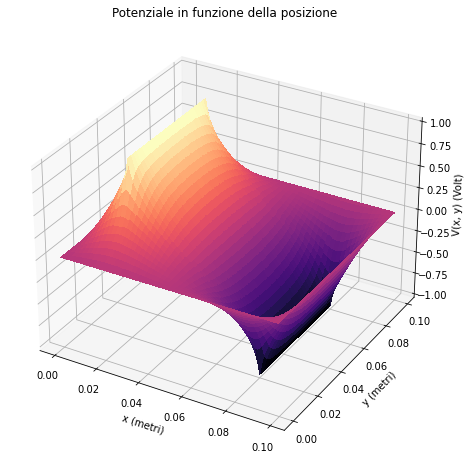

In [8]:
# Calcola il potenziale nella griglia f,
# inoltre restituisce anche il numero di iterazioni per arrivare a convergenza
f, _ = Run(f, rho, h, w, 1e-4, N // 2, pos1, pos2)

# Crea una griglia a partire da due array, combinando tutti gli elementi di x e y
x, y = np.meshgrid([i * h for i in range(N)], [j * h for j in range(N)])

fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")
ax.plot_surface(x, y, f, cmap=cm.magma, linewidth=0, antialiased=False)

ax.set_xlabel("x (metri)")
ax.set_ylabel("y (metri)")
ax.set_zlabel("V(x, y) (Volt)")
ax.set_title("Potenziale in funzione della posizione")
fig.set_figwidth(8)
fig.set_figheight(8)

In [ ]:
fig1, ax1 = plt.subplots()
ax1.contour(x, y, f, levels = 50)
ax1.set_xlabel("x (metri)")
ax1.set_ylabel("y (metri)")
ax1.set_title("linee equipotenziali")
ax1.axis("equal")

fig1.set_figwidth(8)
fig1.set_figheight(8)

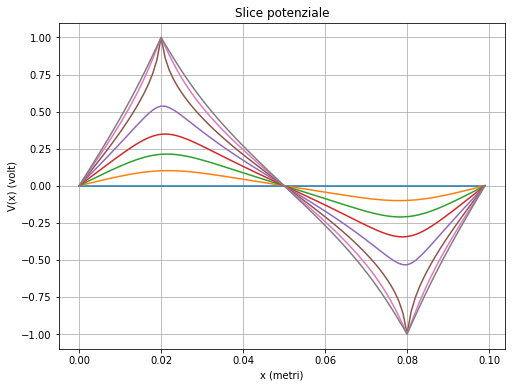

In [14]:
fig3, ax3 = plt.subplots()
ax3.grid(True)

# Prende il potenziale in fette che dividono la scatola orizzontalmente
# man mano che ci si sposta verso il centro
for i in range(0, 30, 4):
    ax3.plot(y[:,0], f[i, :])

ax3.set_xlabel("x (metri)")
ax3.set_ylabel("V(x) (volt)")
ax3.set_title("Slice potenziale")

fig3.set_figwidth(8)
fig3.set_figheight(6)
# fig3.savefig("SlicePot.png", dpi=300)

In [ ]:
# Crea un array di 30 pesi diversi tra 1.7 e 1.99
w1_array = np.linspace(1.7, 1.9, 20)
w2_array = np.linspace(1.9, 2.0, 10)
w_array = np.concatenate((w1_array, w2_array))
w_array[-1] = 1.99
iter_w = np.size(w_array)

# Conterrà il numero di iterazioni per ogni peso
NStep_array = np.zeros(iter_w)

In [ ]:
# Grafico delle iterazioni di SOR rispetto ai pesi w
# Calcola la griglia per ogni peso e restituisce il numero di iterazioni
for i in range(iter_w):
    f = np.zeros((N, N))
    f, NStep_array[i] = Run(f, rho, h, w_array[i], 1e-4, N // 2, pos1, pos2)

In [ ]:
NStep_array = np.loadtxt("Nsteps(100x100).txt")
fig2, ax2 = plt.subplots()
ax2.plot(w_array, NStep_array)
ax2.set_xlabel("Pesi $\omega$")
ax2.set_ylabel("# iterazioni SOR")
ax2.set_yscale("Log")
ax2.set_title("# iterazioni al variare del peso $\omega$ per griglia 100x100")
plt.grid(True)

# Trova il peso ottimale cercando il numero minimo di iterazioni
# per arrivare a convergenza
min_steps = NStep_array[0]
for i in range(iter_w):
    if(NStep_array[i] < min_steps):
        min_steps = NStep_array[i]
    w_ottimale = w_array[i]

print("Peso ottimale :", w_ottimale)
print("# iterazioni minimo :", min_steps)
ax2.annotate(f'Peso ottimale = {round(w_ottimale, 2)}', xytext=(1.70, 500), xy=(w_ottimale-0.01, 331), arrowprops={'facecolor':'black'})
ax2.annotate(f'# minimo di iterazioni = {min_steps}', xytext=(1.70, 600), xy=(w_ottimale-0.01, 331))
ax2.scatter(w_ottimale, min_steps, color="red", s=30)

fig2.set_figwidth(8)
fig2.set_figheight(6)
# fig2.savefig("iterconomega.png", dpi=300)

In [ ]:
# Nomi dei file
nomi = ["1.png", "2.png", "3.png", "4.png", "5.png", "6.png", "7.png", "8.png"
        , "9.png", "10.png", "11.png", "12.png", "13.png", "14.png", "15.png" 
        , "16.png"]

fig4, ax4 = plt.subplots()
fig6, ax6 = plt.subplots()

fig4.set_figwidth(8)
fig4.set_figheight(8)

fig6.set_figwidth(8)
fig6.set_figheight(6)
ax4.grid(True)

ax6.set_xlabel("x (metri)")
ax6.set_ylabel("y (metri)")
ax6.axis("equal")
ax6.set_title("linee equipotenziali")

ax4.set_xlabel("x (metri)")
ax4.set_ylabel("V(x) (volt)")
ax4.set_title("Potenziale al centro per distanze diverse")

# array delle possibili posizioni nella griglia
pos = np.arange(0, 101, 1)
# Prende solo alcune posizioni per la prima piastra
pos1 = pos[2 : N//2 - 1 : 3]
# Calcola le posizioni per la seconda piastra
pos2 = pos[-pos1] - 1
ndist = np.size(pos2)
NStep_array = np.zeros(ndist)

# Crea il grafico del potenziale nella fetta centrale per diverse distanze
# Inoltre crea il grafico delle linee di livello per ogni distanza
for i in range(ndist):
    f = np.zeros((N, N))
    f, NStep_array[i] = Run(f, rho, h, w, 1e-4, N // 2, pos1[i], pos2[i])
    x, y = np.meshgrid([j * h for j in range(N)], [k * h for k in range(N)])
    ax4.plot(y[:, 0], f[N//2, :])
    # ax6.contour(x, y, f, levels = 50)
    # fig6.savefig(nomi[i], dpi=300)
    # ax6.cla()

# fig4.savefig("PotCentroDist.png", dpi=300)

In [ ]:
# Grafico Numero di iterazioni al variare della distanza tra le piastre
fig5, ax5 = plt.subplots()
ax5.set_ylabel("# iterazioni SOR")
ax5.set_xlabel("distanza piastre (metri)")
ax5.set_title("# iterazioni in funzione della distanza tra le piastre")

# array con le distanze tra le piastre
distanze = pos2 - pos1

ax5.plot(distanze, NStep_array)
ax5.grid(True)

fig5.set_figwidth(8)
fig5.set_figheight(6)
# fig5.savefig("itercondist.png", dpi=300)

In [ ]:
# crea un array con i pesi da 1.7 a 1.99
w1_array = np.linspace(1.7, 1.9, 20)
w2_array = np.linspace(1.9, 2.0, 10)
w_array = np.concatenate((w1_array, w2_array))
w_array[-1] = 1.99
iter_w = np.size(w_array)

# array con le varie grandezze della griglia
N_array = np.arange(45, 100, 5)
iter_N = np.size(N_array)
pos1 = pos2 = np.zeros(iter_N)
# Calcola la posizione delle piastre al variare della griglia
pos1 = (1/5) * N_array
pos2 = N_array - pos1
# trasforma in interi dato che verranno usati come indici
pos1 = pos1.astype(int)
pos2 = pos2.astype(int)

NStep_array = np.zeros((iter_N, iter_w))

In [ ]:
# Grafico w_ottimale in funzione della grandezza della griglia
for i in range(iter_N):
    for j in range(iter_w):
        f = np.zeros((N_array[i], N_array[i]))
        f, NStep_array[i, j] = Run(f, rho, h, w_array[j], 1e-4, N_array[i] // 2, pos1[i], pos2[i])

In [ ]:
# Calcola il peso ottimale per ogni griglia e lo mette in un array
w_ottimale_array = np.zeros(iter_N)
for j in range(iter_N):
    min_steps = NStep_array[j, 0]
    for i in range(iter_w):
        if(NStep_array[j, i] < min_steps):
            min_steps = NStep_array[j, i]
            w_ottimale_array[j] = w_array[i]

In [ ]:
# Crea il grafico con il peso ottimale
# in funzione della grandezza della griglia
fig7, ax7 = plt.subplots()

fig7.set_figwidth(8)
fig7.set_figheight(6)
ax7.grid(True)

ax7.set_ylabel("Peso ottimale $\omega$")
ax7.set_xlabel("Grandezza griglia")
ax7.set_title("Peso ottimale in funzione della grandezza della griglia")

w_ottimale_array = np.loadtxt("w_ottimale_array.txt")
ax7.scatter(N_array, w_ottimale_array)

# fig7.savefig("Pesoottegrandezzagrig.png", dpi=300)

In [ ]:
# Crea quattro grafici del potenziale nella fetta centrale
# Variando la grandezza della griglia: 25, 50, 75, 100

# array con le varie grandezze della griglia
N_array = np.array([25, 50, 75, 100])
iter_N = np.size(N_array)
w = 1.87
pos1 = pos2 = np.zeros(iter_N)
# Calcola la posizione delle piastre al variare della griglia
pos1 = (1/5) * N_array
pos2 = N_array - pos1

# Spaziatura punti della griglia
h_array = L / N_array

fig8, ax8 = plt.subplots()

ax8.set_ylabel("Potenziale (volt)")
ax8.set_xlabel("x (metri)")
ax8.set_title("Potenziale retta a 3.48 cm dal centro")

for i in range(iter_N):
    f = np.zeros((N_array[i], N_array[i]))
    f, _ = Run(f, rho, h_array[i], w, 1e-4, N_array[i] // 2, pos1[i], pos2[i])
    x, y = np.meshgrid([k * h_array[i] for k in range(N_array[i])], [j * h_array[i] for j in range(N_array[i])])
    ax8.plot(y[:, 0], f[N_array[i]//8, :], label=f"griglia {N_array[i]}x{N_array[i]}")
    ax8.legend()

ax8.grid(True)
# fig8.savefig("Pot348.png", dpi=300)

In [ ]:
# Calcola il potenziale in griglie di grandezza diversa

# array con le varie grandezze della griglia
N_array = np.arange(20, 205, 5)
iter_N = np.size(N_array)
w = 1.87
pos1 = pos2 = np.zeros(iter_N)
# Calcola la posizione delle piastre al variare della griglia
pos1 = (1/5) * N_array
pos2 = N_array - pos1

# Spaziatura punti della griglia
h_array = L / N_array

# Array che conterrà il massimo, per ogni griglia,
# della fetta di potenziale distante 3.48 cm dal centro
max_pot = np.zeros(iter_N)

for i in range(iter_N):
    f = np.zeros((N_array[i], N_array[i]))
    f, _ = Run(f, rho, h_array[i], w, 1e-4, N_array[i] // 2, pos1[i], pos2[i])
    max_pot[i] = np.max(f[N_array[i]//8, :])
    

In [ ]:
max_pot = np.loadtxt("massimi.txt")
fig9, ax9 = plt.subplots()

ax9.set_title("Vaiazione potenziale")
ax9.set_ylabel("Potenziale (Volt)")
ax9.set_xlabel("Grandezza griglia")

ax9.plot(N_array, max_pot)

#fig9.savefig("max_potGraf.png", dpi=300)